# Deploy a gluoncv model

This notebook is designed to prepare a gluoncv model for deployment. This notebook borrows heavily from this source:

https://github.com/aws-samples/sagemaker-yolov3-detection-server/blob/master/mxnet_detection_serving.ipynb

I *really* like the gluoncv models, since they're pre-trained and much more accurate than the model I trained on my own. However, in testing, it takes nearly 2x as long for inference against a gluoncv model than the model I trained. I suspect this is due to the optization of the algorithm I originally used within SageMaker.

When deploying, SageMaker container images are listed here:

https://github.com/aws/deep-learning-containers/blob/master/available_images.md

In [1]:
!pip install gluoncv

In [1]:
import os
import tarfile
import boto3
import datetime
import json

import matplotlib.pyplot as plt

from mxnet import gluon, nd, image
from mxnet.gluon.data.vision import transforms
import gluoncv.data
from gluoncv import utils
from gluoncv.model_zoo import get_model

Set up the default bucket to store the model in

In [2]:
import sagemaker
from sagemaker import get_execution_role

sess = sagemaker.Session()

bucket = sess.default_bucket()  # We use this bucket to store model weights - don't hesitate to change.
print('using bucket ' + bucket)

using bucket sagemaker-us-east-1-122554519915


In [3]:
model_name = 'ssd_512_resnet50_v1_coco'
net = get_model(model_name, pretrained=True)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


181189KB [00:03, 51331.98KB/s]                            


We're only interested in cars, so set the classes to only identify those

In [4]:
classes = ['car']

net.reset_class(classes=classes, reuse_weights=classes)
print('new classes: ', net.classes)

net.hybridize()  # hybridize to optimize computation

new classes:  ['car']


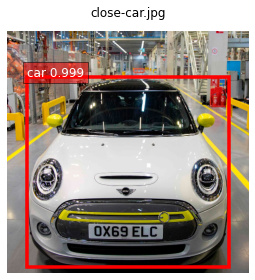

In [5]:
picnames = ['close-car.jpg']

for i, pic in enumerate(picnames):
    im_array =  image.imread(pic)
    x, orig_img = gluoncv.data.transforms.presets.ssd.transform_test(im_array, short=512)
    
    # forward pass and display
    box_ids, scores, bboxes = net(x)
    ax = utils.viz.plot_bbox(orig_img, bboxes[0], scores[0], box_ids[0], class_names=classes, thresh=0.9)
    ax.axis("off")
    ax.set_title(pic, pad=15)
plt.tight_layout()    
plt.show();

## Save the model in the right format and save to S3

In [6]:
# save the full model (both weights and graph)
net.export(model_name, epoch=0)

In [7]:
# compress
packname = 'model.tar.gz'
tar = tarfile.open(packname, 'w:gz')
tar.add('{}-symbol.json'.format(model_name))
tar.add('{}-0000.params'.format(model_name))
tar.close()

In [8]:
# send to s3
s3 = boto3.client('s3')
s3key = 'detection-artifact'
s3.upload_file(packname, bucket, s3key + '/' + packname)

### Write detection model in SageMaker MXNet specification

In [9]:
# we will store the script in the 'repo' directory
!mkdir repo

mkdir: cannot create directory ‘repo’: File exists


In [10]:
%%writefile repo/requirements.txt
gluoncv 

Overwriting repo/requirements.txt


In [11]:
%%writefile repo/detection_server.py

import argparse
import ast
import logging
import os

from gluoncv import model_zoo, data, utils
import mxnet as mx
from mxnet import nd, gluon


def get_ctx():
    "function to get machine hardware context"
    try:
        _ = mx.nd.array([0], ctx=mx.gpu())
        ctx = mx.gpu()
    except:
        try:
            _ = mx.nd.array([0], ctx=mx.eia())
            ctx = mx.eia()
        except: 
            ctx = mx.cpu()
    return ctx


def model_fn(model_dir):
    """
    Load the gluon model. Called once when hosting service starts.
    :param: model_dir The directory where model files are stored.
    :return: a model (in this case a Gluon network)
    
    assumes that the parameters artifact is {model_name}.params
    """
    
    ctx = get_ctx()
    logging.info('Using ctx {}'.format(ctx))
    logging.info('Dir content {}'.format(os.listdir()))
    
    # instantiate net and reset to classes of interest
    net = gluon.nn.SymbolBlock.imports(
        symbol_file=[f for f in os.listdir() if f.endswith('json')][0],
        input_names=['data'],
        param_file=[f for f in os.listdir() if f.endswith('params')][0],
        ctx=ctx)
    
    return net

def input_fn(request_body, request_content_type):
    """prepares the input"""
        
    im_array = mx.image.imdecode(request_body)
    
    # Run SSD pre-processing on CPU
    x, _ = data.transforms.presets.ssd.transform_test(im_array, short=512)
    logging.info('input_fn returns NDArray of shape ' + str(im_array.shape))
    
    return x

def predict_fn(input_object, model):
    """function used for prediction"""
    
    ctx = get_ctx()
    logging.info('Using ctx {}'.format(ctx))
    
    # forward pass and display
    box_ids, scores, bboxes = model(input_object.as_in_context(ctx))
    
    return nd.concat(box_ids, scores, bboxes, dim=2)  # return a single tensor

Overwriting repo/detection_server.py


In [12]:
from sagemaker.mxnet.model import MXNetModel

model = MXNetModel(
    model_data='s3://{}/{}/{}'.format(bucket, s3key, packname),
    role=get_execution_role(),
    py_version='py3',
    entry_point='detection_server.py',
    source_dir='repo',
    framework_version='1.6.0'
)

In [13]:
%%time

# this may take 5 to 10min
model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.xlarge',
    endpoint_name='ml-bike-inference-gluon')

-------------!CPU times: user 12.1 s, sys: 1.31 s, total: 13.4 s
Wall time: 6min 46s


### Now let's test this via a batch transform!

In [17]:
import time

def start_batch_transformation(model_name, s3_input_path, s3_output_path):
    timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
    batch_job_name="vehicle-classification" + timestamp
    batch_input = s3_input_path
    request = \
    {
        "TransformJobName": batch_job_name,
        "ModelName": model_name,
        "MaxConcurrentTransforms": 25,
        "MaxPayloadInMB": 4,
        "BatchStrategy": "SingleRecord",
        "TransformOutput": {
            "S3OutputPath": s3_output_path
        },
        "TransformInput": {
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": batch_input
                }
            },
            "ContentType": "application/x-image",
            "SplitType": "None",
            "CompressionType": "None"
        },
        "TransformResources": {
                "InstanceType": "ml.p3.2xlarge",
                "InstanceCount": 1
        }
    }
    sagemaker = boto3.client('sagemaker')
    sagemaker.create_transform_job(**request)

    return batch_job_name

model_name = '<MODEL_NAME>'
batch_job_name = start_batch_transformation(model_name, 
                's3://<BUCKET_NAME>/bike/CYQ_0006/',
                's3://<BUCKET_NAME>/batch_inference/CYQ_0006/')

sagemaker = boto3.client('sagemaker')

while(True):
    response = sagemaker.describe_transform_job(TransformJobName=batch_job_name)
    status = response['TransformJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed')

    print(status)
    time.sleep(30)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Transform job ended with status: Completed


In [18]:
import matplotlib.image as mpimg
import io

def visualize_detection(img_file, dets, thresh, img_height, img_width):
    SCALE_FACTOR = 1.89             #Scaling factor used to resize the bounding box from the inference image size
    
    bb_list = []
    overlapped_images = []

    for item in dets[0]:
        box_ids, scores, bboxes = item[0],item[1],item[2:]
        
        if scores > thresh:
            bb_list.append(bboxes)
        
    #bike rectangle
    bike_width = 0.65
    bike_height = 0.25
    bike_left = 0.13
    bike_top = 0.75

    bike_x1 = int(bike_left * img_width)
    bike_y1 = int(bike_top * img_height)
    bike_x2 = int(bike_left * img_width + bike_width * img_width)
    bike_y2 = int(bike_top * img_height + bike_height * img_height)

    for item in bb_list:
        xmin, ymin, xmax, ymax = item[0], item[1], item[2], item[3]

        xmin = int(xmin * SCALE_FACTOR)
        xmax = int(xmax * SCALE_FACTOR)
        ymin = int(ymin * SCALE_FACTOR)
        ymax = int(ymax * SCALE_FACTOR)

        if (xmax >= bike_x1 and bike_x2 >= xmin) and (ymax >= bike_y1 and bike_y2 >= ymin):
            overlapped_images.append(img_file)
            break                                 #We only care about the first collision

    return overlapped_images


    
def check_for_collisions(s3_input_bucket, s3_input_prefix, s3_output_bucket, s3_output_prefix):
    s3 = boto3.client('s3')
    response = s3.list_objects(Bucket=s3_input_bucket, Prefix=s3_input_prefix)

    threshold = .9

    overlapped_images = []

    height = 0
    width = 0
    
    for key in response['Contents']:
        file_name = key['Key']

        file_name1 = file_name.split("/")
        file_name_without_prefix = file_name1[len(file_name1) - 1]
        
        if height == 0 or width == 0:
            s3_stream = boto3.resource('s3')
            bucket = s3_stream.Bucket(s3_input_bucket)
            object = bucket.Object(file_name)
            
            with open('sample-img.jpg', 'wb') as data:
                object.download_fileobj(data)
            
            img=mpimg.imread('sample-img.jpg')
            height = img.shape[0]
            width = img.shape[1]
            

        key = s3_output_prefix + file_name_without_prefix + '.out'
        
        result = s3.get_object(Bucket=s3_input_bucket,Key=key)["Body"].read().decode('ascii')
        detections = json.loads(result)
        overlapped_images.append(visualize_detection(file_name, detections, threshold, height, width))

    return overlapped_images

input_bucket = '<INPUT_BUCKET_NAME>'
input_prefix = 'bike/CYQ_0006/'
output_bucket = '<OUTPUT_BUCKET_NAME>'
output_prefix = 'batch_inference/CYQ_0006/'

print('Looking for potential collisions')
encounters = check_for_collisions(input_bucket, input_prefix, output_bucket, output_prefix)

Looking for potential collisions


In [19]:
class videoframe:
    def __init__(self, start_second, end_second):
        self.start_second = start_second
        self.end_second = end_second
        
def generate_clip_times(encounters):
    frame_list = []
    for item in encounters:
        if not item:
            continue

        #We've saved the frame rate as part of the file name, for ease of processing
        file_parts = item[0].split("_")

        frame_rate = file_parts[len(file_parts) - 2]
        frame_part = file_parts[len(file_parts) - 1]
        frame_num = frame_part.split(".")[0]
        beginning_sec = int(int(frame_num) / int(float(frame_rate)))

        frame_start_second = max(0, beginning_sec - 5)
        frame_end_second = beginning_sec + 5

        found_frame = False
        for frame in frame_list:
            if (frame.end_second >= frame_start_second and frame_end_second >= frame.start_second) :
                found_frame = True
                frame.start_second = max(0, min(frame.start_second, frame_start_second))
                frame.end_second = max(frame.end_second,frame_end_second)

        if found_frame == False:
            frame_list.append(videoframe(frame_start_second, frame_end_second))

    return frame_list

frames = generate_clip_times(encounters)
for item in frames:
    print('{}:{}'.format(item.start_second, item.end_second))

1:11
12:28
37:48
53:75
82:95
131:158
182:193
213:225
244:257
269:279
